In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

  Using cached langgraph-0.2.74-py3-none-any.whl.metadata (17 kB)
  Using cached langchain_groq-0.2.4-py3-none-any.whl.metadata (3.0 kB)
  Using cached langgraph_checkpoint-2.0.16-py3-none-any.whl.metadata (4.6 kB)
  Using cached langgraph_sdk-0.1.53-py3-none-any.whl.metadata (1.8 kB)
  Using cached langchain_core-0.3.37-py3-none-any.whl.metadata (5.9 kB)
  Using cached httpx_sse-0.4.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached msgpack-1.1.0-cp312-cp312-win_amd64.whl.metadata (8.6 kB)
Using cached langgraph-0.2.74-py3-none-any.whl (151 kB)
Using cached langchain_groq-0.2.4-py3-none-any.whl (14 kB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ------------ --------------------------- 0.8/2.5 MB 2.4 MB/s eta 0:00:01
   ------------------------ --------------- 1.6/2.5 MB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 3.3 MB/s eta 0:00:00
   -------------------

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

In [3]:
!pip install arxiv wikipedia

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11705 sha256=33c63ab1aab1e28c271c8cdd5662e48e5c0f03e83c3db26f507dbdc4d8ac9ad8
  Stored in directory: c:\users\jadit\appdata\local\pip\cache\wheels\63\47\7c\a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6060 sha256=1e092801383fe9bfcb11dcca13b5e43b3f356cffd0e626b9e876193df9ea99a3
  Stored in directory: c:\users\jadit\appdata\local\pip\cache\wheels\03\f5\1a\23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built wikipedia sgmllib3k


In [4]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [5]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [6]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [7]:
tools=[wiki_tool]

In [8]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [9]:
from langgraph.graph import StateGraph,START,END

In [10]:
graph_builder= StateGraph(State)


In [11]:
from langchain_groq import ChatGroq

In [12]:
import os
from dotenv import load_dotenv
load_dotenv()
# GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
# TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
groq_api_key=os.getenv("GROQ_API_KEY")

In [13]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A29E8940B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A29E895220>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
llm_with_tools=llm.bind_tools(tools=tools)

In [15]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [16]:
from langgraph.prebuilt import ToolNode,tools_condition

In [17]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [18]:
graph=graph_builder.compile()

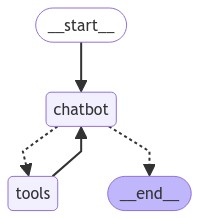

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
user_input="Hi there!, My name is Swapnil"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is Swapnil
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_gdj1)
 Call ID: call_gdj1
  Args:
    query: Swapnil
================================= Tool Message =================================
Name: wikipedia

Page: Swapnil Joshi
Summary: Swapnil Joshi (Marathi pronunciation: [sʋəpniːl d͡ʒoʃiː]) is an Indian film and television actor, in Hindi and Marathi languages. At nine years old, he appeared in the Ramanand Sagar show Uttar Ramayan. He has done some of the most successful series in television such as
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_0wjc)
 Call ID: call_0wjc
  Args:
    query: Swapnil Joshi's filmography
================================= Tool Message =================================
Name: wikipedia

Page: Swapnil Joshi
Summary: Swapnil Joshi 

In [20]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_f95d)
 Call ID: call_f95d
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other models.


In [22]:
user_input = "How to build snake game in python also give me python code for that."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How to build snake game in python also give me python code for that.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_fddg)
 Call ID: call_fddg
  Args:
    query: how to make a snake game in python
================================= Tool Message =================================
Name: wikipedia

Page: Monty Python and the Holy Grail in popular culture
Summary: Monty Python and the Holy Grail was released in 1975 and is a British comedy satire film of the Arthurian legend. It was written by the Monty Python comedy group, consisting of comedians Graham Chapman, John Cleese, Terry Gilliam, Eri
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_7xdd)
 Call ID: call_7xdd
  Args:
    query: how to make a snake game in python
================================= Tool Message =====================